In [25]:
import itk
import os

import numpy as np

In [26]:
data_folder = "/playpen-raid2/lin.tian/data/BraTS-Reg/BraTSReg_Training_Data_v3"
case_list = os.listdir(data_folder)
case_list = list(filter(lambda x: "BraTS" in x.split("/")[-1], case_list))

In [27]:
len(case_list)

140

In [28]:
case_path = case_list[13]
file_list = os.listdir(f"{data_folder}/{case_path}")
source_list = list(filter(lambda x: ("_00_" in x) and ("t1.nii" in x), file_list))
target_list = list(filter(lambda x: ("_01_" in x) and ("t1.nii" in x), file_list))
source = itk.imread(f"{data_folder}/{case_path}/{source_list[0]}")
target = itk.imread(f"{data_folder}/{case_path}/{target_list[0]}")

#new_size = [int(round(osz*ospc/nspc)) for osz,ospc,nspc in zip(original_size, original_spacing, new_spacing)]
#source_resample = sitk.Resample(volume, new_size, sitk.Transform(), interpolator,
#                          volume.GetOrigin(), new_spacing, volume.GetDirection(), 0,
#                          volume.GetPixelID())

print(itk.size(target))
new_size = np.array(source.shape) * np.array(source.GetSpacing()) / np.array((1.5, 1.5, 1.5))
print(new_size)
new_size = list(map(lambda x: int(x), new_size[::-1]))


interpolator = itk.LinearInterpolateImageFunction.New(source)
source_resample = itk.resample_image_filter(
    source,
    interpolator=interpolator,
    size=new_size,
    output_spacing=(1.5, 1.5, 1.5),
    output_direction=source.GetDirection(),
    output_origin=source.GetOrigin(),
)

interpolator = itk.LinearInterpolateImageFunction.New(target)

target_resample = itk.resample_image_filter(
    target,
    interpolator=interpolator,
    size=new_size,
    output_spacing=(1.5, 1.5, 1.5),
    output_direction=target.GetDirection(),
    output_origin=target.GetOrigin(),
)

source_resample.shape

itkSize3 ([240, 240, 155])
[103.33333333 160.         160.        ]


(103, 160, 160)

In [29]:
source.GetSpacing()

itkVectorD3 ([1, 1, 1])

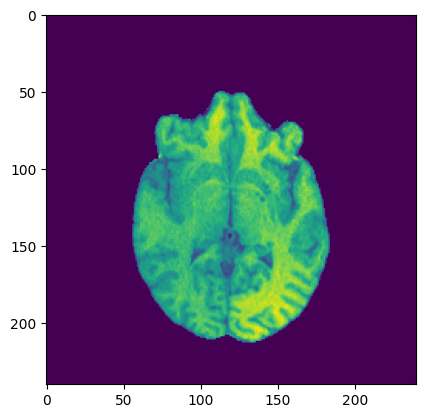

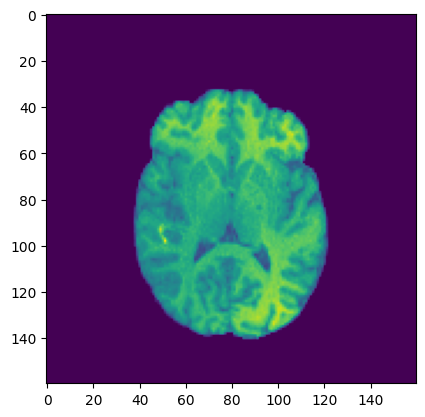

In [30]:
import matplotlib.pyplot as plt

plt.imshow(source[70])
plt.show()

plt.imshow(source_resample[50])
plt.show()

In [31]:
another_mri = itk.imread("/playpen-raid2/Data/HCP/HCP_1200/182739/T1w/T1w_acpc_dc.nii.gz")
another_mri.shape

(260, 311, 260)

In [59]:
import icon_registration
import icon_registration.pretrained_models
import icon_registration.itk_wrapper

image_A = source_resample
image_B = target_resample
image_A_processed = icon_registration.pretrained_models.brain_network_preprocess(
            image_A
        )

image_B_processed = icon_registration.pretrained_models.brain_network_preprocess(
    image_B
)

model = icon_registration.pretrained_models.brain_registration_model(
            pretrained=True
        )
phi_AB, phi_BA = icon_registration.itk_wrapper.register_pair(
            model, image_A_processed, image_B_processed, finetune_steps=50
        )

assert isinstance(phi_AB, itk.CompositeTransform)
interpolator = itk.LinearInterpolateImageFunction.New(source_resample)

warped_image_A = itk.resample_image_filter(
    image_A,
    transform=phi_AB,
    interpolator=interpolator,
    size=itk.size(image_B),
    output_spacing=itk.spacing(image_B),
    output_direction=image_B.GetDirection(),
    output_origin=image_B.GetOrigin(),
)

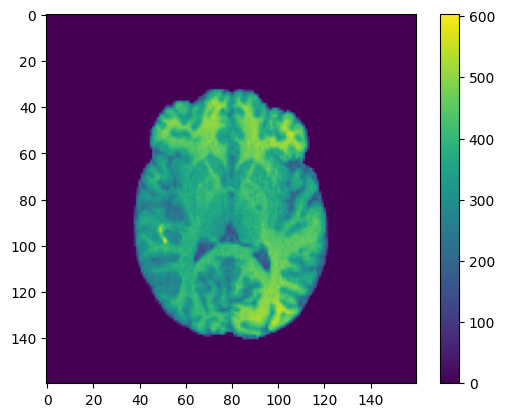

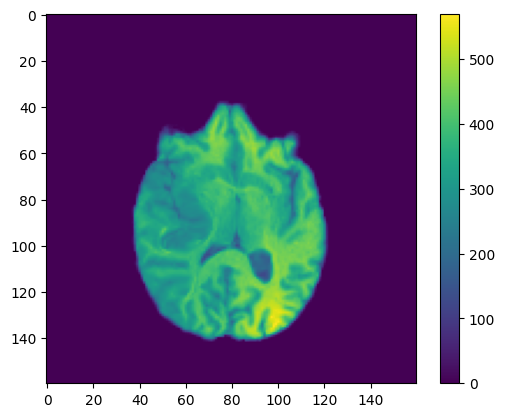

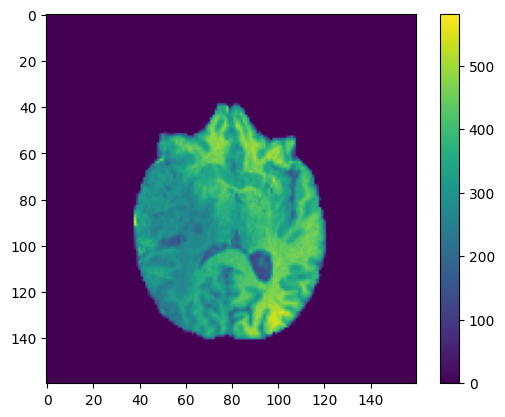

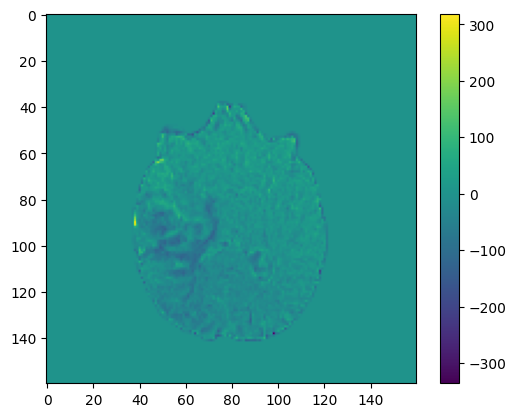

In [60]:
import matplotlib.pyplot as plt
slice_id = 50

#plt.imshow(
#            np.array(itk.checker_board_image_filter(warped_image_A, image_B, checker_pattern=(10,10,10)))[slice_id]
#        )
#plt.show()

plt.imshow(image_A[slice_id])
plt.colorbar()
plt.show()

plt.imshow(warped_image_A[slice_id])
plt.colorbar()
plt.show()

plt.imshow(image_B[slice_id])
plt.colorbar()
plt.show()

plt.imshow(image_B[slice_id]-warped_image_A[slice_id])
plt.colorbar()
plt.show()

In [61]:
np.max(np.array(image_A_processed))

0.9

In [62]:
type(image_A) == itk.Image[itk.SS, 3]

True

In [63]:
itk.Image[itk.SS, 3]

itk.itkImagePython.itkImageSS3

In [64]:
import pandas as pd

In [65]:
source_list

['BraTSReg_077_00_0000_t1.nii.gz']

In [66]:
source_landmarks = pd.read_csv(
    f"{data_folder}/{case_path}/{[f for f in file_list if '_00_' in f and 'landmarks' in f][0]}"
).values[:, 1:]
target_landmarks = pd.read_csv(
    f"{data_folder}/{case_path}/{[f for f in file_list if '_01_' in f and 'landmarks' in f][0]}"
).values[:, 1:]

In [67]:
source_landmarks

array([[  79, -120,   72],
       [ 103, -103,   60],
       [ 109,  -83,   65],
       [  65,  -95,   64],
       [ 118,  -91,   72],
       [  68, -120,   74],
       [  77, -103,   64],
       [ 105,  -90,   58],
       [ 121, -111,   83],
       [  82, -127,   78],
       [  90, -141,   59],
       [ 107, -131,   60],
       [ 133, -131,   62],
       [ 129, -129,   55],
       [ 149, -135,   61],
       [ 138, -105,   62],
       [ 135, -126,   64],
       [ 172,  -86,   70],
       [ 120, -137,   60]])

In [68]:
warped_target_landmarks = np.array([list(phi_AB.TransformPoint(t)) for t in target_landmarks * 1.0])

In [69]:
source_landmarks

array([[  79, -120,   72],
       [ 103, -103,   60],
       [ 109,  -83,   65],
       [  65,  -95,   64],
       [ 118,  -91,   72],
       [  68, -120,   74],
       [  77, -103,   64],
       [ 105,  -90,   58],
       [ 121, -111,   83],
       [  82, -127,   78],
       [  90, -141,   59],
       [ 107, -131,   60],
       [ 133, -131,   62],
       [ 129, -129,   55],
       [ 149, -135,   61],
       [ 138, -105,   62],
       [ 135, -126,   64],
       [ 172,  -86,   70],
       [ 120, -137,   60]])

In [70]:
warped_target_landmarks

array([[  77.58970894, -121.18094392,   71.64578876],
       [ 100.52890834, -106.50966814,   60.83992241],
       [ 106.02884312,  -82.75783682,   66.10516631],
       [  64.30478949,  -95.82308774,   65.47060924],
       [ 116.66406871,  -90.93296219,   73.11940514],
       [  67.08799211, -122.08130883,   72.89873138],
       [  77.43464053, -105.21567756,   67.00192547],
       [ 102.23970629,  -90.54589338,   59.46770779],
       [ 122.62254971, -113.43983912,   82.4095117 ],
       [  79.20619038, -128.20925783,   76.54206924],
       [  89.36486155, -141.18372861,   59.82520723],
       [ 103.32168501, -130.93490239,   62.19211229],
       [ 132.7306307 , -130.02881582,   62.24067002],
       [ 128.32010211, -127.46238543,   56.29513045],
       [ 149.95885469, -135.62417413,   61.40787691],
       [ 137.92739283, -105.15039485,   61.38989117],
       [ 132.85536318, -124.92792819,   63.66143681],
       [ 171.26896922,  -85.59566328,   69.31346744],
       [ 120.37065079, -136.

In [71]:
np.sqrt(np.sum((source_landmarks - warped_target_landmarks)**2, axis=1)).mean()

2.3737782707408877

In [45]:
file_list

['BraTSReg_077_01_0122_flair.nii.gz',
 'BraTSReg_077_01_0122_t1.nii.gz',
 'BraTSReg_077_01_0122_t1ce.nii.gz',
 'BraTSReg_077_01_0122_t2.nii.gz',
 'BraTSReg_077_00_0000_t1ce.nii.gz',
 'BraTSReg_077_00_0000_t1.nii.gz',
 'BraTSReg_077_00_0000_flair.nii.gz',
 'BraTSReg_077_01_0122_landmarks.csv',
 'BraTSReg_077_00_0000_landmarks.csv',
 'BraTSReg_077_00_0000_t2.nii.gz']